In [16]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence


from fitter import Fitter, get_common_distributions


In [15]:
!pip install fitter

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.1/47.1 KB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 59.0/59.0 KB 1.5 MB/s eta 0:00:00
Using legacy 'setup.py install' for fitter, since package 'wheel' is not installed.
Using legacy 'setup.py install' for easydev, since package 'wheel' is not installed.
  Running setup.py install for easydev: started
  Running setup.py install for easydev: finished with status 'done'
  Running setup.py install for fitter: started
  Running setup.py install for fitter: finished with status 'done'


You should consider upgrading via the 'C:\Users\agarc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv("california.csv", index_col = 0)
df.head()

,id,state,gender,median_home_val,median_household_income,ic2,ic3,ic4,ic5,avggift,target_d
0,44060,FL,M,1158.437751,392.0,430.0,466.0,520.0,21975.0,NaN,100.0
1,96093,IL,M,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667,7.0
2,43333,FL,F,725.000000,301.0,340.0,361.0,436.0,18837.0,4.111111,5.0
3,21885,NC,M,1158.437751,401.0,407.0,399.0,413.0,14014.0,27.277778,38.0
4,190108,FL,F,995.000000,252.0,280.0,316.0,348.0,17991.0,6.000000,5.0


In [39]:
df.drop(["target_d", "id"], axis = 1, inplace = True)

In [40]:
df.head()

,state,gender,median_home_val,median_household_income,ic2,ic3,ic4,ic5,avggift
0,FL,M,1158.437751,392.0,430.0,466.0,520.0,21975.0,NaN
1,IL,M,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667
2,FL,F,725.000000,301.0,340.0,361.0,436.0,18837.0,4.111111
3,NC,M,1158.437751,401.0,407.0,399.0,413.0,14014.0,27.277778
4,FL,F,995.000000,252.0,280.0,316.0,348.0,17991.0,6.000000


# Análisis exploratorio

Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.

Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco.

Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo (más sobre esto en los siguientes apartados).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3993 entries, 0 to 3992
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3993 non-null   int64  
 1   state                    3984 non-null   object 
 2   gender                   3993 non-null   object 
 3   median_home_val          3793 non-null   float64
 4   median_household_income  3873 non-null   float64
 5   ic2                      3985 non-null   float64
 6   ic3                      3913 non-null   float64
 7   ic4                      3953 non-null   float64
 8   ic5                      3594 non-null   float64
 9   avggift                  3713 non-null   float64
 10  target_d                 3993 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 374.3+ KB


In [10]:
# Número de datos ausentes por variable
# ==============================================================================
df.isna().sum()

id                           0
state                        9
gender                       0
median_home_val            200
median_household_income    120
ic2                          8
ic3                         80
ic4                         40
ic5                        399
avggift                    280
target_d                     0
dtype: int64

**Variable respuesta**

Cuando se crea un modelo, es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir. La variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.

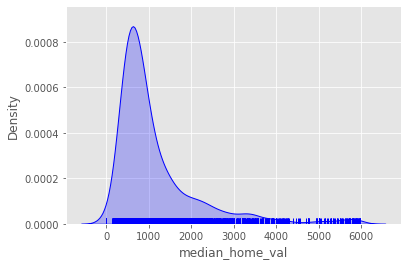

In [12]:
# vamos a ver visualmente como está distribuida la variable respuesta

sns.distplot(
    df.median_home_val,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1}
);


In [19]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']
fitter = Fitter(df.median_home_val, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
expon,inf,inf,inf,inf
cauchy,inf,inf,inf,inf
chi2,inf,inf,inf,inf
gamma,inf,inf,inf,inf
logistic,inf,inf,inf,inf
powerlaw,inf,inf,inf,inf
beta,inf,inf,inf,inf
exponpow,inf,inf,inf,inf
norm,NaN,NaN,NaN,NaN


## Variables numéricas


In [41]:
# Variables numéricas
# ==============================================================================
df.select_dtypes(include=['float64', 'int']).describe()

,median_home_val,median_household_income,ic2,ic3,ic4,ic5,avggift
count,3793.000000,3873.000000,3985.000000,3913.000000,3953.000000,3594.000000,3713.000000
mean,1157.846955,350.773044,400.785445,400.104779,444.426006,16518.241235,11.765914
std,1029.069398,167.547484,180.689566,164.914233,174.990268,9633.072224,10.283029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.260870
25%,548.000000,238.000000,284.000000,287.000000,325.000000,11139.000000,7.153846
50%,805.000000,318.000000,366.000000,365.000000,410.000000,14392.000000,10.000000
75%,1353.000000,424.000000,478.000000,480.000000,528.000000,18812.000000,14.444444
max,5982.000000,1500.000000,1500.000000,1311.000000,1331.000000,174523.000000,450.000000


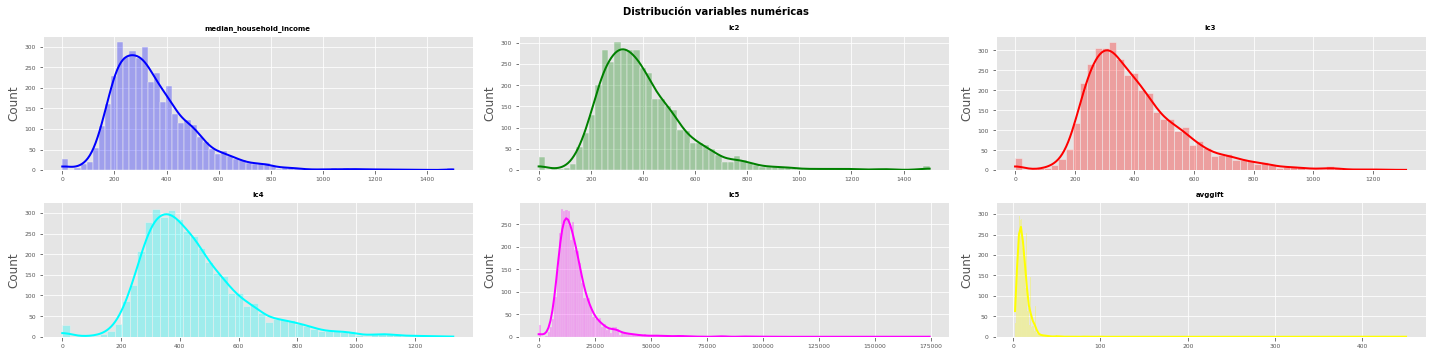

In [44]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))
lista_colores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('median_home_val')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = lista_colores[i],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");



Como el objetivo del estudio es predecir el precio de las viviendas, el análisis de cada variable se hace también en relación a la variable respuesta precio. Analizando los datos de esta forma, se pueden empezar a extraer ideas sobre qué variables están más relacionadas con el precio y de qué forma.

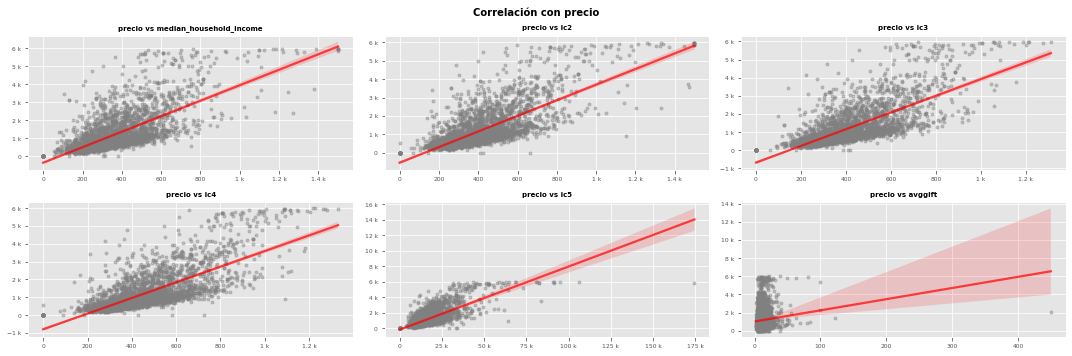

In [47]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('median_home_val')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = df[colum],
        y           = df['median_home_val'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

## Correlación entre variables numéricas

## Variables cualitativas

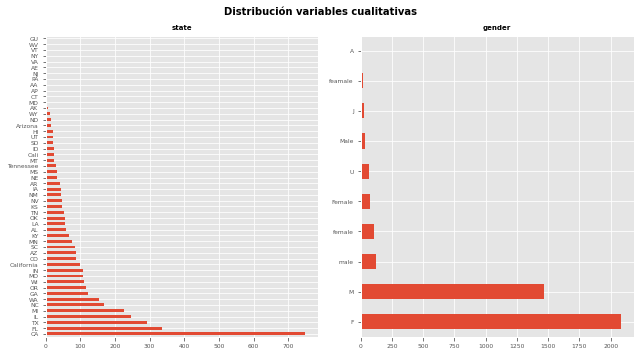

In [50]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

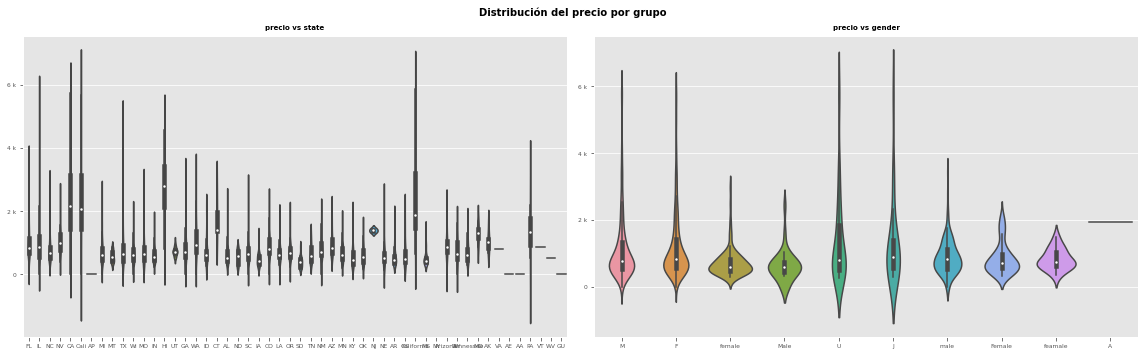

In [53]:
# Gráfico relación entre el precio y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'median_home_val',
        data  = df,
        ax    = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 10, fontweight = "bold");

# Preprocesado

Esto ya lo hemos hecho. 

# Crear el modelo

## Separación train-test

In [54]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X = df.drop('median_home_val', axis =1)
y = df['median_home_val']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8)